# https://www.kaggle.com/datasets/oyekanmiolamilekan/fake-employee-dataset

In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import hashlib
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [143]:
pd.set_option('display.max_columns', None)

In [144]:
df = pd.read_csv("fake_employee.csv")
df.head()

,employee_id,name,gender,dates_of_birth,email,phone_number,address,department,job_titles,manager_id,hire_date,salary,employment_status,employee_type,education_level,certifications,skills,performance_ratings,work_experience,benefits_enrollment,city,work_hours,employee_status,emergency_contacts
0,6612,Martha Hutchinson,Male,1970-11-14,randy09@example.net,708-895-4293x86180,"5301 Norman Flats Apt. 965\r\nNorth Darrell, P...",Finance,Administrator,10,2023-04-06,77367,Part-time,Regular,Master's Degree,team,"senior, kitchen, president, call, station",3,Receive determine pass find. Authority laugh r...,"data, cell, people",Hollandberg,9-5,Active,Alicia Payne: 001-469-835-3679x07176
1,4793,Meghan Cervantes,Non-Binary,1992-08-20,matthewsnyder@example.com,001-727-813-2133x30484,"7917 Vincent Trafficway Apt. 254\r\nHallhaven,...",Finance,Mental health nurse,8,2022-05-26,81869,Full-time,Temporary,PhD,"whether, some, measure","perhaps, knowledge, officer",4,Prevent meet bill computer upon keep receive. ...,"appear, discover",East Sabrinafurt,9-5,Active,Brandy Lopez: +1-642-314-0561x6900
2,8832,April Hanna,Male,1986-04-17,lwood@example.net,+1-758-402-2437x248,"646 Courtney Hollow\r\nSouth Marc, LA 67617",Finance,Field seismologist,6,2020-06-11,97907,Part-time,Temporary,PhD,"job, week","tend, official, red",4,Necessary Congress real.,"stop, woman",New Garyfurt,9-5,Active,Craig Rivera: 267.574.5240x08971
3,7044,George Yang,Non-Binary,2001-03-15,ellen93@example.net,001-682-318-3829x45513,"3930 Kelly Wells Apt. 574\r\nPaulton, OR 22142",Engineering,"Nurse, children's",5,2020-11-25,110034,Part-time,Regular,PhD,"position, similar","question, their, health, single, whole",2,Yard whose different trade. Free foreign quest...,"product, either",Christophermouth,12-8,On Leave,Lauren Davis: 423.534.7439
4,4498,Joseph Patrick,Male,1998-10-09,patriciacollins@example.net,001-790-812-0148x64174,"0493 Lane Avenue\r\nSmithburgh, IN 65374",Engineering,Meteorologist,2,2021-01-12,70091,Contractor,Contract,Bachelor's Degree,"table, seem","how, government, finally, east, strong",4,Agreement tax chair strategy bring kid assume ...,"gas, commercial",South Jamestown,Night Shift,Terminated,Antonio Ferguson: +1-425-489-9331


In [145]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   employee_id          1000 non-null   int64 
 1   name                 1000 non-null   object
 2   gender               1000 non-null   object
 3   dates_of_birth       1000 non-null   object
 4   email                1000 non-null   object
 5   phone_number         1000 non-null   object
 6   address              1000 non-null   object
 7   department           1000 non-null   object
 8   job_titles           1000 non-null   object
 9   manager_id           1000 non-null   int64 
 10  hire_date            1000 non-null   object
 11  salary               1000 non-null   int64 
 12  employment_status    1000 non-null   object
 13  employee_type        1000 non-null   object
 14  education_level      1000 non-null   object
 15  certifications       1000 non-null   object
 16  skills 

,employee_id,manager_id,salary,performance_ratings
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,5527.310000,5.454000,81531.299000,2.991000
std,2546.946895,2.837241,23216.141548,1.406021
min,1022.000000,1.000000,40027.000000,1.000000
25%,3351.500000,3.000000,61903.750000,2.000000
50%,5559.000000,5.000000,82902.000000,3.000000
75%,7732.750000,8.000000,101614.750000,4.000000
max,9995.000000,10.000000,119987.000000,5.000000


In [146]:
cols_to_remove = [
    'employee_id', 'name', 'email', 'phone_number', 'address',
    'dates_of_birth', 'skills', 'emergency_contacts'
]

# Show unique value count before dropping
print(df[cols_to_remove + ['manager_id', 'work_hours']].nunique())

# Drop only non-useful columns
df.drop([col for col in cols_to_remove if col in df.columns], axis=1, inplace=True)

# Convert to string for categorical encoding later
df['manager_id'] = df['manager_id'].astype(str)
df['work_hours'] = df['work_hours'].astype(str)

# Round salary to nearest 5000
df['salary'] = (df['salary'] // 5000) * 5000

# Keep a clean original version for comparison
df_original = df.copy()


employee_id            952
name                   995
email                  998
phone_number          1000
address               1000
dates_of_birth         974
skills                1000
emergency_contacts    1000
manager_id              10
work_hours               3
dtype: int64


# Functions

In [147]:
def preprocess_for_ml(df):
    y = df['salary']
    X = df.drop(columns=['salary'])  # Drop the target column (target = salary)

    # Replace '*' with np.nan and fill
    X = X.replace('*', np.nan).fillna('Missing')

    # Encode categorical variables using LabelEncoder
    for col in X.select_dtypes(include='object').columns:
        encoder = LabelEncoder()
        X[col] = encoder.fit_transform(X[col].astype(str))

    return X, y


In [148]:
# Evaluation function to use in both original and anonymized datasets
def evaluate_on_dataset(df, label=''):
    X, y = preprocess_for_ml(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"✅ {label}: MAE = {mae:.2f} | R² = {r2:.4f}")
    return {'label': label, 'mae': mae, 'r2': r2}


In [149]:

# Function to train and evaluate models
def train_and_evaluate(model, X_train, X_test, y_train, y_test, label=''):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Model ({label}) - MAE: {mae:.2f}")
    return mae


In [150]:

# Training and evaluation function for all models
def evaluate_models(X_train, X_test, y_train, y_test):
    models = [
        (RandomForestRegressor(random_state=42), "Random Forest"),
        (LinearRegression(), "Linear Regression"),
        (DecisionTreeRegressor(random_state=42), "Decision Tree"),
        (GradientBoostingRegressor(random_state=42), "Gradient Boosting")
    ]
    
    results = {}
    for model, label in models:
        mae = train_and_evaluate(model, X_train, X_test, y_train, y_test, label)
        results[label] = mae

    return results


# Pre-processing

In [151]:
# Use the original dataset (with PII)
df_original = df.copy()



In [152]:
df[["salary"]].head()

,salary
0,75000
1,80000
2,95000
3,110000
4,70000


In [153]:
# Round salary to the nearest 5,000
df['salary'] = (df['salary'] // 5000) * 5000


In [154]:
df[["salary"]].head()

,salary
0,75000
1,80000
2,95000
3,110000
4,70000


## Feature Engineering

In [155]:
df['hire_date'] = pd.to_datetime(df['hire_date'], errors='coerce')
df['years_experience'] = datetime.now().year - df['hire_date'].dt.year
df['years_experience'] = df['years_experience'].fillna(df['years_experience'].median())

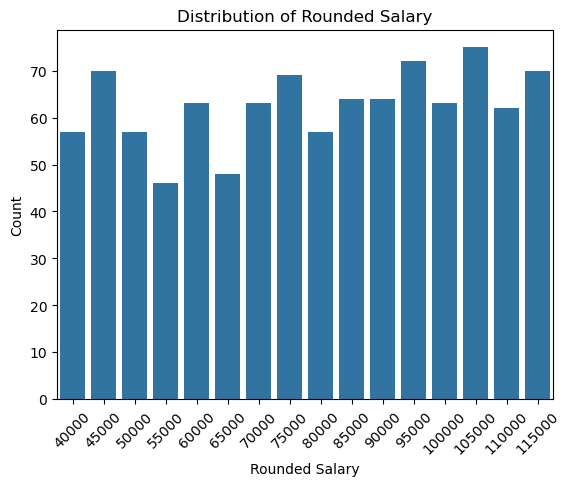

In [156]:
# Create a countplot for the rounded salary (assuming 'rounded_salary_5000' is the column)
sns.countplot(data=df, x='salary')
plt.title('Distribution of Rounded Salary')
plt.xlabel('Rounded Salary')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [157]:
# Evaluate on original + anonymized datasets
all_results = []

for k in [0, 2, 5, 10, 15, 20]:
    if k == 0:
        df_k = df_original.copy()
        label = "Original"
    else:
        df_k = apply_k_anonymity(df_original.copy(), k)
        label = f"k={k}"
    X, y = preprocess_for_ml(df_k)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_maes = evaluate_models(X_train, X_test, y_train, y_test)
    for model_name, mae in model_maes.items():
        all_results.append({'k': k, 'label': label, 'model': model_name, 'mae': mae})

results_df = pd.DataFrame(all_results)


Model (Random Forest) - MAE: 19421.75
Model (Linear Regression) - MAE: 18963.89
Model (Decision Tree) - MAE: 25625.00
Model (Gradient Boosting) - MAE: 19471.93
✅ Anonymization for k=2:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAE: 19323.75
Model (Linear Regression) - MAE: 18955.11
Model (Decision Tree) - MAE: 24200.00
Model (Gradient Boosting) - MAE: 19923.26
✅ Anonymization for k=5:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAE: 19701.50
Model (Linear Regression) - MAE: 18948.02
Model (Decision Tree) - MAE: 27500.00
Model (Gradient Boosting) - MAE: 20107.94
✅ Anonymization for k=10:
 - Unique QID combinations: 25
 - Suppressed cells (NaN): 1000 / 3000 (33.33%)
Model (Random Forest) - MAE: 19199.50
Model (Linear Regression) - MAE: 18880.45
Model (Decision Tree) - MAE: 26725.00
Model (Gradient Boosting) - MAE: 19723.92
✅ Anonymization for k=15:
 - Unique QID combinations: 2

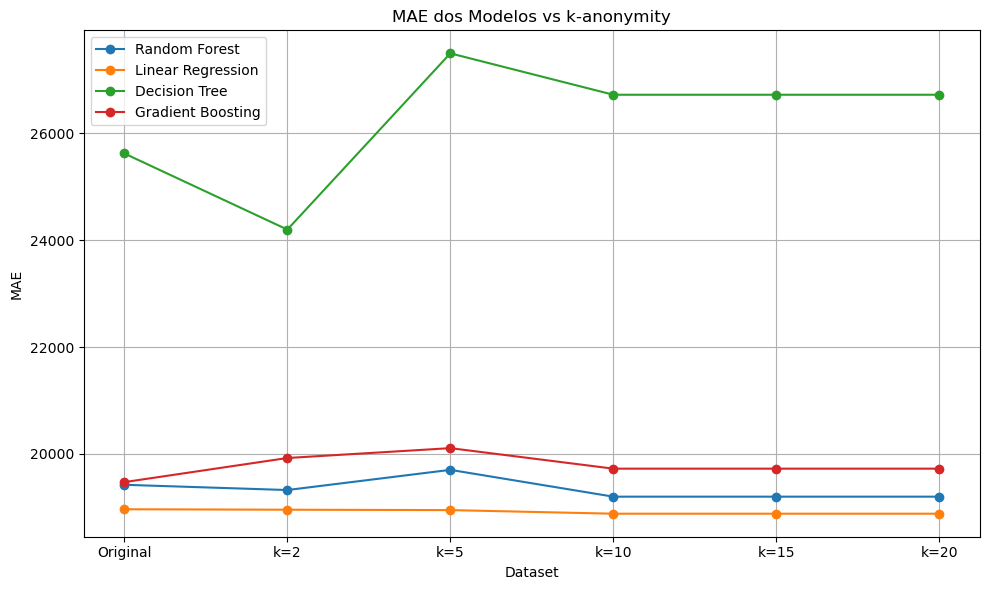

In [158]:
plt.figure(figsize=(10, 6))
for model in results_df['model'].unique():
    subset = results_df[results_df['model'] == model]
    plt.plot(subset['label'], subset['mae'], marker='o', label=model)
plt.title('MAE dos Modelos vs k-anonymity')
plt.xlabel('Dataset')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# K-1 Anonymity

In [159]:
def apply_k_anonymity(df, k):
    df = df.copy()
    
    # Define quasi-identifiers
    QIDs = ['gender', 'department', 'education_level']
    
    # Generalization based on k level
    def generalize(row):
        # Gender
        if k >= 5 and isinstance(row['gender'], str):
            row['gender'] = row['gender'][0]  # Só a inicial
        # City
        if k >= 10 and isinstance(row['city'], str):
            row['city'] = row['city'][:2]    # Só as 2 primeiras letras
        elif k >= 5 and isinstance(row['city'], str):
            row['city'] = row['city'][:3]    # Só as 3 primeiras letras
        # Department
        if k >= 5 and isinstance(row['department'], str):
            if any(x in row['department'] for x in ['IT', 'Tech', 'Developer']):
                row['department'] = 'Tech'
            elif any(x in row['department'] for x in ['HR', 'Admin']):
                row['department'] = 'Admin'
            else:
                row['department'] = 'Other'
        # Job Titles
        if k >= 10 and isinstance(row['job_titles'], str):
            row['job_titles'] = " ".join(row['job_titles'].split()[:1])
        elif k >= 5 and isinstance(row['job_titles'], str):
            row['job_titles'] = " ".join(row['job_titles'].split()[:2])
        # Hire Date
        try:
            parsed_date = pd.to_datetime(row['hire_date'], errors='coerce')
            if pd.isna(parsed_date):
                row['hire_date'] = 'Missing'
            elif k >= 10:
                row['hire_date'] = parsed_date.year // 10 * 10  # Década
            elif k >= 5:
                row['hire_date'] = parsed_date.year
            elif k >= 2:
                row['hire_date'] = parsed_date.strftime('%Y-%m')
        except:
            row['hire_date'] = 'Missing'
        return row

    df = df.apply(generalize, axis=1)
    # Group by QIDs and get group sizes
    group_sizes = df.groupby(QIDs).size().reset_index(name='counts')

    # Identify groups with fewer than k
    small_groups = group_sizes[group_sizes['counts'] < k]

    # Suppression for small groups
    def suppress(row):
        is_small = ((small_groups[QIDs] == row[QIDs]).all(axis=1)).any()
        if is_small:
            for col in QIDs:
                row[col] = np.nan
        return row

    # Apply suppression
    df = df.apply(suppress, axis=1)

    # Contagem realista de células anonimizadas
    total_qid_cells = df[QIDs].size
    suppressed_cells = df[QIDs].isna().sum().sum()
    percent = (suppressed_cells / total_qid_cells) * 100

    print(f"✅ Anonymization for k={k}:")
    print(f" - Unique QID combinations: {df[QIDs].drop_duplicates().shape[0]}")
    print(f" - Suppressed cells (NaN): {suppressed_cells} / {total_qid_cells} ({percent:.2f}%)")

    return df


In [160]:
df[["salary"]]

,salary
0,75000
1,80000
2,95000
3,110000
4,70000
...,...
995,85000
996,105000
997,70000
998,45000


In [161]:
# Check how many unique values exist in each QID column
qid_check_cols = ['gender', 'department', 'education_level']
for col in qid_check_cols:
    print(f"{col}: {df[col].nunique()} unique values")


gender: 3 unique values
department: 5 unique values
education_level: 5 unique values


## K=2

In [162]:
k = 2
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k2 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=2:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAE: 19366.50
Model (Linear Regression) - MAE: 18978.24
Model (Decision Tree) - MAE: 24925.00
Model (Gradient Boosting) - MAE: 19570.73


In [163]:
# Preview of the anonymized QID columns
df_anonymous[['gender', 'department', 'education_level']].head()


,gender,department,education_level
0,Male,Finance,Master's Degree
1,Non-Binary,Finance,PhD
2,Male,Finance,PhD
3,Non-Binary,Engineering,PhD
4,Male,Engineering,Bachelor's Degree


## K=5

In [164]:

k = 5
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k5 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=5:
 - Unique QID combinations: 45
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAE: 19650.25
Model (Linear Regression) - MAE: 18913.83
Model (Decision Tree) - MAE: 24900.00
Model (Gradient Boosting) - MAE: 19718.88


## K=10

In [165]:
k = 10
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k10 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=10:
 - Unique QID combinations: 44
 - Suppressed cells (NaN): 48 / 3000 (1.60%)
Model (Random Forest) - MAE: 19406.75
Model (Linear Regression) - MAE: 18962.75
Model (Decision Tree) - MAE: 24850.00
Model (Gradient Boosting) - MAE: 19993.02


## K=15

In [166]:
k = 15
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k15 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=15:
 - Unique QID combinations: 22
 - Suppressed cells (NaN): 858 / 3000 (28.60%)
Model (Random Forest) - MAE: 19345.25
Model (Linear Regression) - MAE: 18971.18
Model (Decision Tree) - MAE: 24525.00
Model (Gradient Boosting) - MAE: 19603.73


## K=20

In [167]:
k = 20
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k20 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=20:
 - Unique QID combinations: 16
 - Suppressed cells (NaN): 1152 / 3000 (38.40%)
Model (Random Forest) - MAE: 19038.50
Model (Linear Regression) - MAE: 18897.28
Model (Decision Tree) - MAE: 22675.00
Model (Gradient Boosting) - MAE: 19984.50


# Attempt to preview salary on the anonymized dataset

In [168]:
# Keep a clean reference to the original salaries
original_salaries = df['salary'].copy()

## Applying the k-anonymity to the dataset

In [169]:
k = 2 # or any k you want to test
df_anonymous = apply_k_anonymity(df.copy(), k)


✅ Anonymization for k=2:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)


## Preprocessing to train

In [170]:
X_processed, _ = preprocess_for_ml(df_anonymous)  
y_true = original_salaries  

# Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_true, test_size=0.2, random_state=42)

# Train a model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔍 Salary prediction on anonymized data (k={k})")
print(f" - MAE: {mae:.2f}")
print(f" - R² Score: {r2:.4f}")


🔍 Salary prediction on anonymized data (k=2)
 - MAE: 19366.50
 - R² Score: -0.0252


## Results interpretation

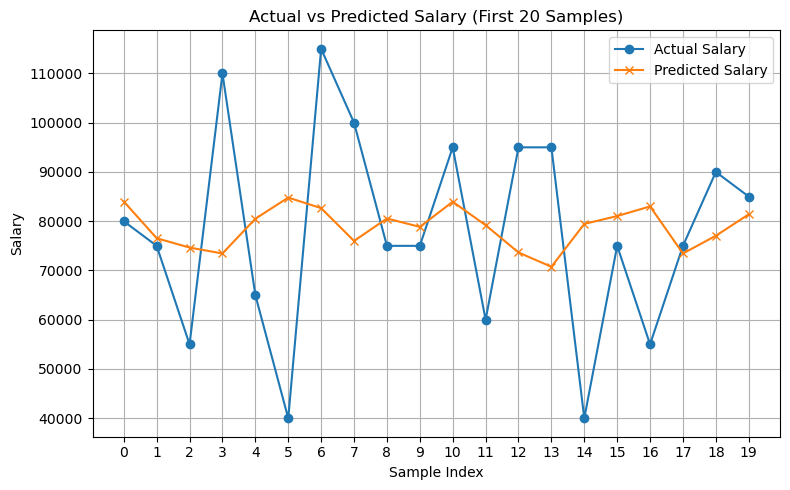

In [171]:
# Create the comparison DataFrame
comparison = pd.DataFrame({
    'Actual Salary': y_test.reset_index(drop=True),
    'Predicted Salary': y_pred
})

comparison_sample = comparison.head(20)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(comparison_sample.index, comparison_sample['Actual Salary'], label='Actual Salary', marker='o')
plt.plot(comparison_sample.index, comparison_sample['Predicted Salary'], label='Predicted Salary', marker='x')
plt.title('Actual vs Predicted Salary (First 20 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Salary')
plt.xticks(comparison_sample.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Classification prevent